# GiveMeSomeCredit

In [96]:
%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [97]:
from sklearn.metrics import classification_report, accuracy_score, auc, f1_score, \
    cohen_kappa_score, confusion_matrix, roc_curve
    
def class_report(y_true, y_pred, title=''):
    print('Classification Report: {}'.format(title))
    print(classification_report(y_true, y_pred))
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('F1:', f1_score(y_true, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    print('AUC:', metrics.auc(fpr, tpr))
    print('Cohen’s κ:', cohen_kappa_score(y_true, y_pred))
    rcp = pylab.rcParams['figure.figsize']
    pylab.rcParams['figure.figsize'] = (3, 2)
    ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', robust=True)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    plt.show()
    pylab.rcParams['figure.figsize'] = rcp
    print()


In [111]:
data = pd.read_csv('data/cs-training.csv', index_col=0, low_memory=False)
test_data = pd.read_csv('data/cs-test.csv', index_col=0, low_memory=False)
data.fillna(-9999, inplace=True)
X, y = data.iloc[:, data.columns != 'SeriousDlqin2yrs'], data['SeriousDlqin2yrs']

In [112]:
sum(data.isnull())

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [113]:
from sklearn.linear_model import LinearRegression

def fill_nas(X, models):
    X_clean = X.drop(models.keys(), axis=1)
    for col, model in models.items():
        is_na, not_na = X[col].isnull(), X[col].notnull()
        # Train
        X_na, y_na = X_clean[not_na], X[col][not_na]
        model.fit(X_na, y_na)
        # Predict
        X.loc[is_na, col] = model.predict(X_clean[is_na])
    return X

data = pd.read_csv('data/cs-training.csv', index_col=0, low_memory=False)
X, y = data.iloc[:, data.columns != 'SeriousDlqin2yrs'], data['SeriousDlqin2yrs']

fillers = dict(MonthlyIncome=LinearRegression(n_jobs=-1),
               NumberOfDependents=LinearRegression(n_jobs=-1))
X = fill_nas(X, fillers)
print(sum(X.isnull()), X.dtypes)

RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64 RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object


/usr/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
#pd.plotting.scatter_matrix(data.head(2000));

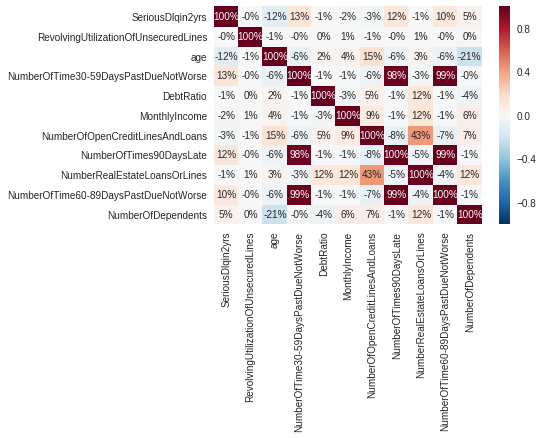

In [114]:
data.corr()
sns.heatmap(data.corr(), annot=True, fmt='.0%');

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1,
                                                    random_state=0)

print('Shape:', X.shape)
X.head()

Shape: (150000, 10)


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [ ]:
from xgboost import XGBClassifier

In [117]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

imp = Imputer(missing_values='NaN', strategy='median', axis=1)

parameters = {'model__learning_rate': [0.3],
              'model__n_estimators': [1000], 
              'model__max_depth': [3]}

pipeline = Pipeline([#('imputer', imp), 
                     #('scale', StandardScaler()),
                     ('model', XGBClassifier(missing=-9999))])

clf = GridSearchCV(pipeline, parameters, 
                   cv=StratifiedKFold(n_splits=3, shuffle=True),
                   scoring='roc_auc', n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)
clf.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.6s finished


{'model__learning_rate': 0.3,
 'model__max_depth': 3,
 'model__n_estimators': 1000}

Classification Report: Training
             precision    recall  f1-score   support

          0       0.95      0.99      0.97    125994
          1       0.79      0.31      0.44      9006

avg / total       0.94      0.95      0.94    135000

Accuracy: 0.9484
F1: 0.441647964091
AUC: 0.650116149795
Cohen’s κ: 0.420129395849


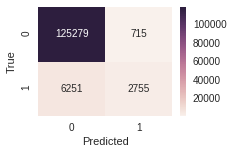


Classification Report: Test
             precision    recall  f1-score   support

          0       0.94      0.99      0.97     13980
          1       0.61      0.20      0.30      1020

avg / total       0.92      0.94      0.92     15000

Accuracy: 0.937
F1: 0.30155210643
AUC: 0.595386266094
Cohen’s κ: 0.277363823227


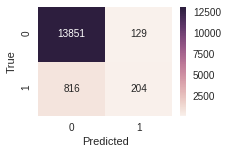

In [118]:
y_train_pred = clf.predict(X_train)# imp.fit_transform(X_train))
y_pred = clf.predict(X_test) #imp.fit_transform(X_test))

class_report(y_train, y_train_pred, 'Training')
class_report(y_test, y_pred, 'Test')

In [162]:
data_submission = pd.read_csv('data/cs-test.csv', index_col=0, low_memory=False)
data_submission.drop('SeriousDlqin2yrs', axis=1, inplace=True)
data_submission.fillna(-9999, inplace=True)

pipeline = Pipeline([#('imputer', imp), 
                     #('scale', StandardScaler()),
                     ('model', XGBClassifier(missing=-9999, n_jobs=-1))])

#clf = GridSearchCV(pipeline, dict([(x, [y]) for x, y in clf.best_params_.items()]), 
#                   scoring='roc_auc', n_jobs=-1, verbose=1)

model = XGBClassifier(learning_rate=0.3, max_depth=3, n_estimators=1000, missing=-9999, n_jobs=8)
model.fit(X, y)
data_submission['SeriousDlqin2yrs'] = model.predict(data_submission)

In [163]:
data_submission.to_csv('submission_20170615.csv')